# CartPole-v0 with LSTM - RNN

In [24]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.contrib import rnn
%matplotlib inline

env = gym.make('CartPole-v0')

tf.reset_default_graph()

NUM_ACTIONS = env.action_space.n  # 0 or 1

n = 4

#################################################################
#################################################################
batch_size = 128
display_step = 10

# Network Parameters
n_input = 4*n # MNIST data input (img shape: 28*28)
# n_steps = 28 # timesteps
n_steps = 1 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 2 # MNIST total classes (0-9 digits)

x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(x, weights, biases):
    # (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    
    # get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, n_steps, 0)
        
    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


#################################################################
#################################################################


inputs1 = tf.placeholder(shape=[None, n_input], dtype=tf.float32)

q_out = RNN(inputs1, weights, biases)
predict = tf.argmax(q_out, 1)

next_q = tf.placeholder(shape=[None, n_classes], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_q - q_out))
update_model = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

init = tf.global_variables_initializer()

discount_factor = 0.99
exploration_rate = 0.3
NUM_EPISODES = 500
MAX_T = 250
DEBUG = True

step_list = []
reward_list = []
prev_states = []
with tf.Session() as sess:
    sess.run(init)
    for episode in range(NUM_EPISODES):
        state_0 = env.reset()
        
        
        reward_all = 0
        t = 0
        while t < MAX_T:
            t += 1
            
            prev_states.append(state_0.reshape((1,4)))
            input_vec_0 = None
            ###############
            if len(prev_states) < n:
                input_vec_0 = np.zeros((1, 4 * (n-len(prev_states))))
                for i in range(len(prev_states)):
                    input_vec_0 = np.concatenate((input_vec_0, prev_states[i]), axis=1)
            else:
                for pr_st in prev_states[-n:]:
                    if input_vec_0 is None:
                        input_vec_0 = pr_st
                    else:
                        input_vec_0 = np.concatenate((input_vec_0, pr_st), axis=1)
            ###############
            
            action, all_q = sess.run([predict, q_out], feed_dict={inputs1:input_vec_0})
#             if t > 300:
#                 exploration_rate = 0.001
                
            if np.random.rand(1) < exploration_rate:
                action[0] = env.action_space.sample()
            
            state, reward, done, _ = env.step(action[0])
            
            
            prev_states.append(state.reshape((1,4)))
            input_vec = None
            ###############
            if len(prev_states) < n:
                input_vec = np.zeros((1, 4 * (n-len(prev_states))))
                for i in range(len(prev_states)):
                    input_vec = np.concatenate((input_vec, prev_states[i]), axis=1)
            else:
                for pr_st in prev_states[-n:]:
                    if input_vec is None:
                        input_vec = pr_st
                    else:
                        input_vec = np.concatenate((input_vec, pr_st), axis=1)
            ###############
            
            q1 = sess.run(q_out, feed_dict={inputs1:input_vec})
    
            max_q1 = np.max(q1)
            
            target_q = all_q
            
            target_q[0, action[0]] = reward + discount_factor * max_q1
            
            _ = sess.run([update_model], feed_dict={inputs1:input_vec_0, next_q:target_q})
            
            reward_all += reward
            state_0 = state
            
            if done:
                if DEBUG:
                    print("Episode {} finished after {} timesteps".format(episode, t))
                break
                
        step_list.append(t)
        reward_list.append(reward_all)
        
print("Average score: {}".format(sum(reward_list)/NUM_EPISODES))
env.close()

[2017-03-10 19:58:08,831] Making new env: CartPole-v0


Episode 0 finished after 9 timesteps
Episode 1 finished after 9 timesteps
Episode 2 finished after 10 timesteps
Episode 3 finished after 14 timesteps
Episode 4 finished after 15 timesteps
Episode 5 finished after 9 timesteps
Episode 6 finished after 8 timesteps
Episode 7 finished after 11 timesteps
Episode 8 finished after 13 timesteps
Episode 9 finished after 12 timesteps
Episode 10 finished after 9 timesteps
Episode 11 finished after 10 timesteps
Episode 12 finished after 14 timesteps
Episode 13 finished after 11 timesteps
Episode 14 finished after 12 timesteps
Episode 15 finished after 31 timesteps
Episode 16 finished after 16 timesteps
Episode 17 finished after 25 timesteps
Episode 18 finished after 20 timesteps
Episode 19 finished after 9 timesteps
Episode 20 finished after 10 timesteps
Episode 21 finished after 13 timesteps
Episode 22 finished after 10 timesteps
Episode 23 finished after 10 timesteps
Episode 24 finished after 13 timesteps
Episode 25 finished after 12 timesteps
Ep

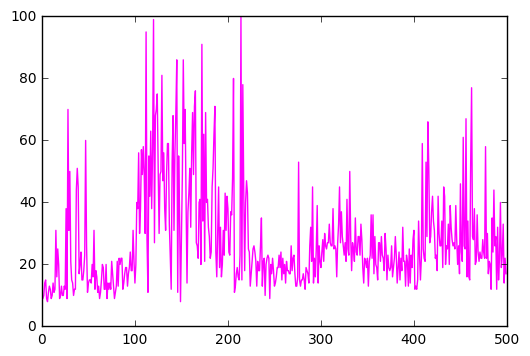

In [27]:
plt.plot(reward_list, color='magenta')